In [1]:
import numpy as np
import torch
from ADEN import ADEN
import torchsummary
from TestCaseGenerator import data_RLClustering
from ADENTrain import TrainDbar,trainY
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
X, M, T_P, N, d = data_RLClustering(4)
X = torch.tensor(X).float().to(device)

Batch_size = 16  # number of batches
num_samples_in_batch = 8  # number of samples in each batch
input_dim = d  # dimensionality of the input space


Y = torch.mean(X, dim=0).to(device) + torch.randn(M, input_dim).to(
    device
)  # example cluster tensor (M, input_dim)

model = ADEN(input_dim=input_dim, d_model=64, n_layers=3, d_ff=128).to(device)

torchsummary.summary(model, [(N, input_dim), (M, input_dim)])
# visualize the model architecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1800, 64]             192
            Linear-2                [-1, 4, 64]             192
            Linear-3             [-1, 1800, 64]           4,096
            Linear-4                [-1, 4, 64]           4,096
            Linear-5                [-1, 4, 64]           4,096
           Dropout-6           [-1, 8, 1800, 4]               0
            Linear-7             [-1, 1800, 64]           4,160
MultiHeadDistanceAttention-8             [-1, 1800, 64]               0
           Dropout-9             [-1, 1800, 64]               0
        LayerNorm-10             [-1, 1800, 64]             128
           Linear-11            [-1, 1800, 128]           8,320
             GELU-12            [-1, 1800, 128]               0
          Dropout-13            [-1, 1800, 128]               0
           Linear-14           

In [3]:
# writing all hyperparameters in one place
EPOCHS_DBAR = 1000
BATCH_SIZE_DBAR = 32
NUM_SAMPLES_IN_BATCH_DBAR = 128
LR_DBAR = 1e-4
WEIGHT_DECAY_DBAR = 1e-5
GAMMA_DBAR = 1000.0
PROBS_DBAR = torch.tensor(T_P)

EPOCHS_TRAIN_Y = 10000
BATCH_SIZE_TRAIN_Y = None
LR_TRAIN_Y = 1e-3
WEIGHT_DECAY_TRAIN_Y = 1e-5
TOL_TRAIN_Y = 1e-6

BETA_INIT = 1e-3
BETA_F = 10.0
BETA_GROWTH_RATE = 10.0
PERTURBATION_STD = 0.01


beta = BETA_INIT
while beta < BETA_F:
    print(f"Beta: {beta:<.4f}")
    Y = Y + torch.randn(M, input_dim).to(device) * PERTURBATION_STD
    TrainDbar(
        model,
        X,
        Y,
        device,
        epochs=EPOCHS_DBAR,
        batch_size=BATCH_SIZE_DBAR,
        num_samples_in_batch=NUM_SAMPLES_IN_BATCH_DBAR,
        lr=LR_DBAR,
        weight_decay=WEIGHT_DECAY_DBAR,
        gamma=GAMMA_DBAR,
        probs=PROBS_DBAR,
    )
    Y, history = trainY(
        model,
        X,
        Y,
        device,
        lr=LR_TRAIN_Y,
        weight_decay=WEIGHT_DECAY_TRAIN_Y,
        beta=beta,
        tol=TOL_TRAIN_Y,
        max_epochs=EPOCHS_TRAIN_Y,
        batch_size=BATCH_SIZE_TRAIN_Y,
        verbose=True,
    )
    beta *= BETA_GROWTH_RATE

Beta: 0.0010
Epoch 0, MSE Loss: 229.64010620117188
Epoch 100, MSE Loss: 9.33521556854248
Epoch 200, MSE Loss: 4.303505897521973
Epoch 300, MSE Loss: 2.7566676139831543
Epoch 400, MSE Loss: 2.089219331741333
Epoch 500, MSE Loss: 1.7438124418258667
Epoch 600, MSE Loss: 1.4504437446594238
Epoch 700, MSE Loss: 1.2700185775756836
Epoch 800, MSE Loss: 1.1726274490356445
Epoch 900, MSE Loss: 1.0352619886398315
[trainY] Epoch 0, F: -2470302.250000
[trainY] Converged at epoch 87, F: -2470559.000000
Beta: 0.0100
Epoch 0, MSE Loss: 0.9610332250595093
Epoch 100, MSE Loss: 0.46771618723869324
Epoch 200, MSE Loss: 0.3027942478656769
Epoch 300, MSE Loss: 0.2107069492340088
Epoch 400, MSE Loss: 0.1605544239282608
Epoch 500, MSE Loss: 0.12326806038618088
Epoch 600, MSE Loss: 0.10454628616571426
Epoch 700, MSE Loss: 0.08617302775382996
Epoch 800, MSE Loss: 0.07309725880622864
Epoch 900, MSE Loss: 0.06339067220687866
[trainY] Epoch 0, F: -224918.562500
[trainY] Epoch 100, F: -225149.687500
[trainY] Epoch

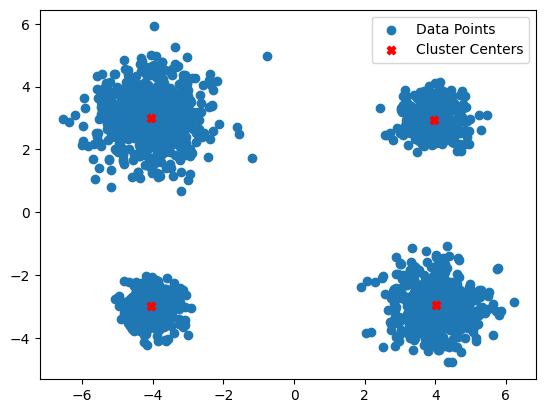

In [5]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = Y.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()